<a href="https://colab.research.google.com/github/OlgaNezh/Computer_Vision/blob/main/HW7_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]



## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
!pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 28.6 MB/s 


## Загрузка и распаковка датасета KTH

In [ ]:
!wget http://www.csc.kth.se/cvap/actions/walking.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip

--2022-10-16 20:30:37--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-10-16 20:30:37--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M  1.27MB/s    in 3m 7s   

2022-10-16 20:33:45 (1.23 MB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-10-16 20:33:45--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c2

## Подготовка датасета для классификации

In [20]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset_data = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
      dataset_data.append((fpath, cls))
print(f'Количество видео: {len(dataset_data)}')

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
Количество видео: 599


## Визуализация кадра из видео

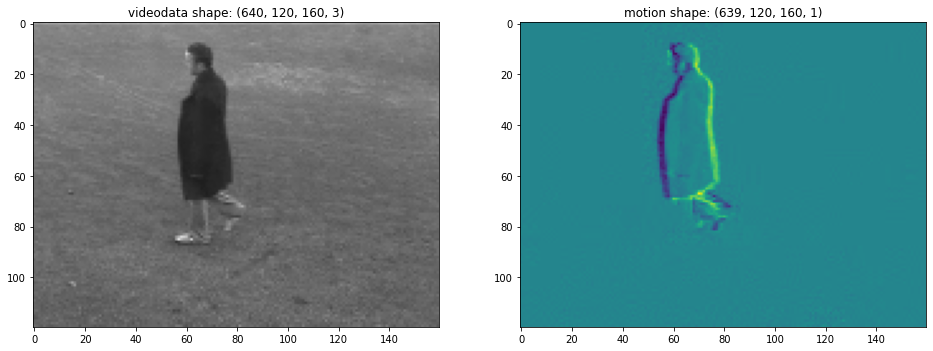

In [21]:
fig = plt.figure(figsize=(16, 8))
ax_1 = fig.add_subplot(1, 2, 1)
videodata = skvideo.io.vread(dataset_data[0][0])
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[50, ...])
plt.title(f'videodata shape: {videodata.shape}')
  
ax_2 = fig.add_subplot(1, 2, 2)
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
plt.imshow(motion[50, ..., 0])
plt.title(f'motion shape: {motion.shape}')
plt.show()

In [22]:
NUM_TRAIN_ELEM = 500
NUM_FRAMES = 200
NUM_EPOCHS = 5
BATCH_SIZE = 2

random.shuffle(dataset_data)

def path_to_motion(video_class, NUM_FRAMES=200):
    videodata = skvideo.io.vread(video_class.numpy()[0].decode('UTF-8'), num_frames=NUM_FRAMES)
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    return motion, classes.index(video_class.numpy()[1].decode('UTF-8'))

def set_shapes(motion, cl_idx):

    motion.set_shape((199, 120, 160, 1))
    cl_idx.set_shape([])
    return motion, cl_idx

train_ds = tf.data.Dataset.from_tensor_slices(dataset_data[:NUM_TRAIN_ELEM])
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(lambda video_class: tf.py_function(func=path_to_motion,
                                                            inp=[video_class], 
                                                           Tout=[tf.float32, tf.uint8]))
train_ds = train_ds.map(lambda x, y: set_shapes(x, y))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тренировочного датасета: {len(train_ds)}')

test_ds = tf.data.Dataset.from_tensor_slices(dataset_data[NUM_TRAIN_ELEM:])
test_ds = test_ds.map(lambda video_class: tf.py_function(func=path_to_motion,
                                                          inp=[video_class], 
                                                         Tout=[tf.float32, tf.uint8]))
test_ds = test_ds.map(lambda x, y: set_shapes(x, y))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тестового датасета: {len(test_ds)}')

Длина тренировочного датасета: 250
Длина тестового датасета: 49


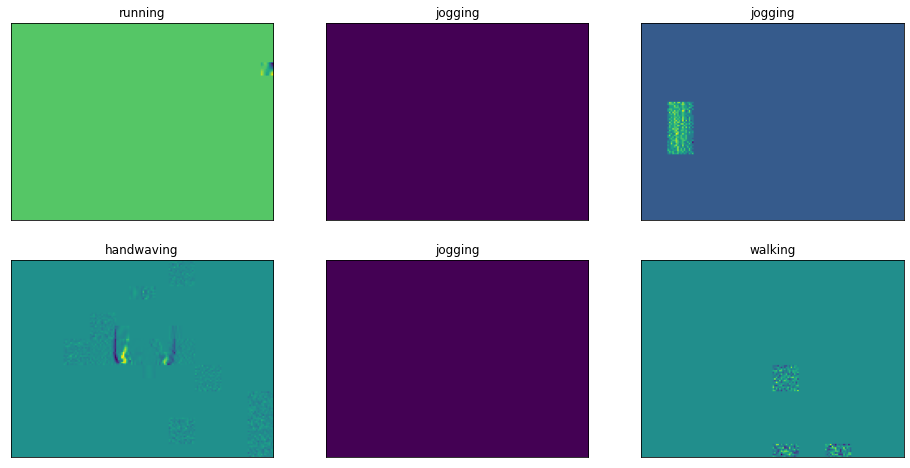

In [23]:
import tensorflow_datasets as tfds
ds_train_np = tfds.as_numpy(train_ds.take(6)) #tf.data.Dataset -> Iterator[Tree[np.array]] (преобразуем датасет в итератор)
fig = plt.figure(figsize=(16, 8))
j = 0
for motion, cl_idx in ds_train_np:
  ax = fig.add_subplot(2, 3, j+1)
  plt.imshow(motion[0][0][...,0])
  plt.xticks([]), plt.yticks([])
  plt.title(classes[cl_idx[0]])
  j += 1
plt.show()

## Создание модели CNN

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None)
])

In [25]:
LEARNING_RATE = 0.001

model.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
         optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
          metrics = ['accuracy']
              )

## Цикл обучения модели

In [13]:
%%time
NUM_EPOCHS = 10

history = model.fit(
                     train_ds,
                     epochs=NUM_EPOCHS,
                     validation_data=test_ds
                    )

Epoch 1/10
250/250 [==============================] - 226s 862ms/step - loss: 1.4263 - accuracy: 0.3560 - val_loss: 1.2047 - val_accuracy: 0.4592
Epoch 2/10
250/250 [==============================] - 215s 861ms/step - loss: 0.7421 - accuracy: 0.6680 - val_loss: 0.8990 - val_accuracy: 0.6531
Epoch 3/10
250/250 [==============================] - 216s 866ms/step - loss: 0.4842 - accuracy: 0.8000 - val_loss: 0.4424 - val_accuracy: 0.8367
Epoch 4/10
250/250 [==============================] - 224s 897ms/step - loss: 0.3943 - accuracy: 0.8680 - val_loss: 0.4547 - val_accuracy: 0.8571
Epoch 5/10
250/250 [==============================] - 220s 880ms/step - loss: 0.2988 - accuracy: 0.8920 - val_loss: 0.3415 - val_accuracy: 0.8980
Epoch 6/10
250/250 [==============================] - 227s 908ms/step - loss: 0.2791 - accuracy: 0.8760 - val_loss: 0.3342 - val_accuracy: 0.9082
Epoch 7/10
250/250 [==============================] - 228s 910ms/step - loss: 0.1974 - accuracy: 0.9340 - val_loss: 0.2343 -

In [14]:
model.evaluate(test_ds)

49/49 [==============================] - 36s 728ms/step - loss: 0.3214 - accuracy: 0.9082


[0.3214260935783386, 0.9081632494926453]

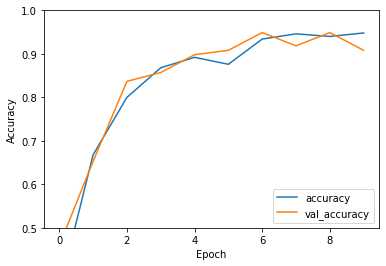

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

## Тестирование обученной модели

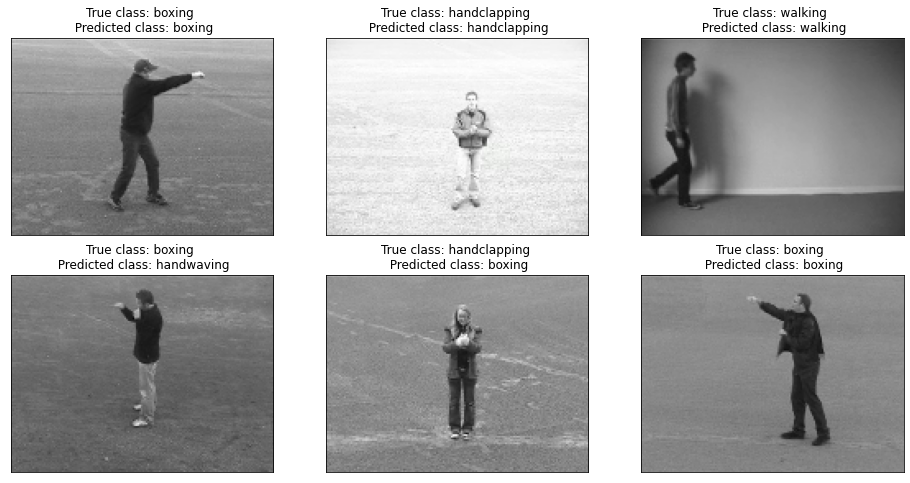

In [17]:
fpath_cls_true_list = random.sample(dataset_data[NUM_TRAIN_ELEM:], 6) 
fig = plt.figure(figsize=(16, 8))
for i in range(len(fpath_cls_true_list)):
  ax = fig.add_subplot(2, 3, i+1)
  videodata = skvideo.io.vread(fpath_cls_true_list[i][0])
  videodata = videodata.astype(np.float32) / 255.
  plt.imshow(videodata[30, ...])
  
  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())
  plt.title(f'True class: {fpath_cls_true_list[i][1]} \n Predicted class: {classes[cls_pred]}')
  plt.xticks([]), plt.yticks([])
plt.show()